In [18]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
from networkx.algorithms.graphical import is_graphical
from networkx.utils.random_sequence import powerlaw_sequence
import matplotlib.pyplot as plt
plt.style.use('../figures/norm.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os
from timeit import default_timer as timer
import cairo
import cmath

def read_pc(filepath):
    """
    Read parity check matrix from file.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    pc = []
    for line in lines:
        row = [int(x) for x in line.split()]
        pc.append(row)
    return np.array(pc, dtype=np.uint8)

def get_classical_code_distance_time_limit(h):
    if rank(h) == h.shape[1]:
        print('Code is full rank, no codewords')
        return np.inf
    else:
        start = timer()
        ker = nullspace(h)
        end = timer()
        def find_min_weight_while_build(matrix):
            span = []
            min_hamming_weight = np.inf
            for ir, row in enumerate(matrix):
                row_hamming_weight = np.sum(row)
                if row_hamming_weight < min_hamming_weight:
                    min_hamming_weight = row_hamming_weight
                temp = [row]
                for element in span:
                    newvec = (row + element) % 2
                    temp.append(newvec)
                    newvec_hamming_weight = np.sum(newvec)
                    if newvec_hamming_weight < min_hamming_weight:
                        min_hamming_weight = newvec_hamming_weight
                    end = timer()
                    if end - start > 5:
                        return min_hamming_weight
                span = list(np.unique(temp + span, axis=0))
            assert len(span) == 2**len(matrix) - 1
            return min_hamming_weight
        min_hamming_weight = find_min_weight_while_build(ker)
        end = timer()
        return min_hamming_weight
    
def get_classical_code_distance_special_treatment(h, target_weight):
    if rank(h) == h.shape[1]:
        print('Code is full rank, no codewords')
        return np.inf
    else:
        start = timer()
        print('Code is not full rank, there are codewords')
        print('Computing codeword space basis ...')
        ker = nullspace(h)
        end = timer()
        print(f'Elapsed time for computing codeword space basis: {end-start} seconds', flush=True)
        print('len of ker: ', len(ker))
        print('Start finding minimum Hamming weight while buiding codeword space ...')
        start = end
        # @jit
        def find_min_weight_while_build(matrix):
            span = []
            min_hamming_weight = np.inf
            for ir, row in enumerate(matrix):
                row_hamming_weight = np.sum(row)
                if row_hamming_weight < min_hamming_weight:
                    min_hamming_weight = row_hamming_weight
                    if min_hamming_weight <= target_weight:
                        assert np.sum(row) == min_hamming_weight
                        return min_hamming_weight, row
                temp = [row]
                for element in span:
                    newvec = (row + element) % 2
                    temp.append(newvec)
                    newvec_hamming_weight = np.sum(newvec)
                    if newvec_hamming_weight < min_hamming_weight:
                        min_hamming_weight = newvec_hamming_weight
                        if min_hamming_weight <= target_weight:
                            assert np.sum(newvec) == min_hamming_weight
                            return min_hamming_weight, newvec
                span = list(np.unique(temp + span, axis=0))
            assert len(span) == 2**len(matrix) - 1
        min_hamming_weight, logical_op = find_min_weight_while_build(ker)
        end = timer()
        print(f'Elapsed time for finding minimum Hamming weight while buiding codeword space : {end-start} seconds', flush=True)
        return min_hamming_weight, logical_op

Code is not full rank, there are codewords
Computing codeword space basis ...
Elapsed time for computing codeword space basis: 0.005251374999716063 seconds
len of ker:  4
Start finding minimum Hamming weight while buiding codeword space ...
Elapsed time for finding minimum Hamming weight while buiding codeword space : 0.00030895800000507734 seconds


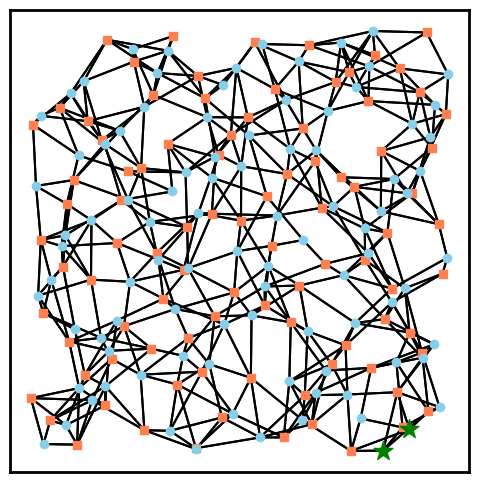

In [24]:
n, m = np.array([100, 100]) * 1
n, m = int(n), int(m)
proportionality = 0.1
const = 8
kappa_max_b = 6
kappa_max_c = 6
kappa_min_b = 3
kappa_min_c = 3
seed = 10

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'
readname = f'pc_local_ldpc_sqrt_deletion_n={n}_m={m}_kappa_max_b={kappa_max_b}_kappa_max_c={kappa_max_c}_kappa_min_b={kappa_min_b}_kappa_min_c={kappa_min_c}_proportionality={proportionality}_const={const}_seed={seed}.txt'
readdataname = f'data_local_ldpc_sqrt_deletion_n={n}_m={m}_kappa_max_b={kappa_max_b}_kappa_max_c={kappa_max_c}_kappa_min_b={kappa_min_b}_kappa_min_c={kappa_min_c}_proportionality={proportionality}_const={const}_seed={seed}.npz'

pc = read_pc(os.path.join(readdir, readname))
data = np.load(os.path.join(readdir, readdataname), allow_pickle=True)
points = data['points']
removed_checks = data['removed_checks']
removed_bits = data['removed_bits']
adj_mat = data['adj_mat']

checks_eff = [check for check in range(m) if check not in removed_checks]
bits_eff = [bit for bit in range(m, m+n) if bit not in removed_bits]

fig, ax = plt.subplots()
check_color = '#FF7F50' # coral
bit_color = '#87CEEB' # sky blue
ax.scatter(points[checks_eff,0], points[checks_eff,1], marker='s', c=check_color)
ax.scatter(points[bits_eff,0], points[bits_eff,1], marker='o', c=bit_color)
for i in checks_eff:
    for j in range(m+n):
        if adj_mat[i, j] == 1:
            ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], color='k', linewidth=1.5, zorder=0)
for i in bits_eff:
    for j in range(m+n):
        if adj_mat[i, j] == 1:
            ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], color='k', linewidth=1.5, zorder=0)

d_bound, logical_op = get_classical_code_distance_special_treatment(pc, 4)
ones = [i for i in range(len(logical_op)) if logical_op[i] == 1]
x = [points[bits_eff[i]][0] for i in ones]
y = [points[bits_eff[i]][1] for i in ones]
ax.scatter(x, y, marker='*', c='g', s=200, zorder=100)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(8, 6)
plt.show()